In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
#Load data.

train_features = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_features.csv')
train_labels = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_labels.csv')
test_features = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/test_features.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/sample_submission.csv')

In [44]:
#Let's take a look at our data.

#This is our core training data.
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [45]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [46]:
test_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [47]:
#Merge train_features and train_labels into one dataframe.

training_data = pd.merge(train_features, train_labels)

In [48]:
#Split our training data into a train and validation set.

from sklearn.model_selection import train_test_split

train, val = train_test_split(training_data, train_size=0.80, test_size=0.20, 
                              stratify=training_data['status_group'], random_state=42)

In [49]:
#Check the shapes.

train.shape, val.shape, test_features.shape

((47520, 41), (11880, 41), (14358, 40))

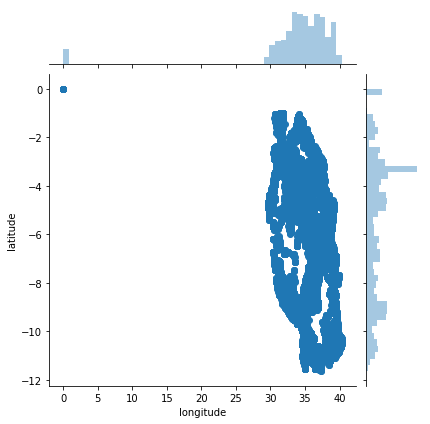

In [50]:
#Honing in on both the latitude feature and longitude feature as being representative of location...
#We call these two features in combination an interaction.

#It's important to note that linear models make the assumption that features are independent of each other,
#and that there is a linear relationship with the target. Tree based models on the other hand can help us 
#model interactions.

#Let's look at a seaborn scatter plot of latitude and longitude.

import seaborn as sns

sns.jointplot(x='longitude', y='latitude', data=train_features);

In [ ]:
#Notice the top left hand corner. Although we didn't have any NaNs or null values in our numeric features, this 
#visualization is representative of something along those lines. Hmmm...

In [51]:
#Let's make some adjustments using reusable functions.

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime.
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded.
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # Also quantity & quantity_group are duplicates, so drop one.
    X = X.drop(columns='quantity_group')
    
    # For categoricals with missing values, fill with the category 'MISSING.'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test_features)

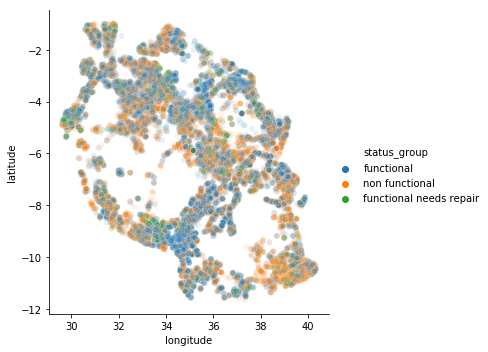

In [52]:
#A scatter plot that's representative of a map of Tanzania.

sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

In [53]:
# The status_group column is the target.

target = 'status_group'

# Get a dataframe with all train columns except the target & id.

train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features.

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the non-numeric features.
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50. Key when using One-hot encoding.
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists.
features = numeric_features + categorical_features

In [54]:
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test; Note: Using robust scaling instead of standard!
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

#Save submission.
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Submission-03.csv', index=False)

Validation Accuracy 0.7281144781144782


In [ ]:
#Get and plot the coefficients.
#We see that quantity_dry is highly predictive of the well being non functional, and quantity_enough is strongly
#predictive of the well being functional.

coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [ ]:
#What if we trained a logistic regression using two features? In this case, using longitude and latitude.

In [55]:
#Make a dataframe using longitude and latitude.

train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

In [56]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
#n_jobs=-1 means to use all the computational power you have available to you.

lr.fit(train_location, y_train)

print('Logistic Regression:')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression:
Train Accuracy 0.5430765993265994
Validation Accuracy 0.5430976430976431


In [ ]:
#We see that trying to train a logistic regression only on latitude and longitude doesn't really end 
#up beating the majority classifier. So, really these features are useless as is to logistic regression.

In [57]:
#Now, let's try this same thing but using a decision tree for our model. 

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_location, y_train)

print('Decision Tree:')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree:
Train Accuracy 0.984196127946128
Validation Accuracy 0.6301346801346801


In [ ]:
#What do we notice?

#We achieve above a 60% accuracy only using those two features with a Decision Tree model. Training accuracy is almost perfect here, but it's
#too good to be true in some sense.

#In comparing validation acurracies between the Logistic Regression and Decision Tree models, we'd choose the Decision
#Tree model given that it has the higher validation accuracy, which is ultimately what we care about. We wouldn't say that
#we can't use the Decision Tree model because it's overfit to the training set. We expect this although it may not be to this
#same degree. In practice, we don't often use individual decision trees. We'll use ensembles of trees much more frequently.
#These can help us reduce the overfitting and even protect against underfitting.
#If you grow a tree to unlimited depth, you'd expect to have a near perfect training accuracy and not as good
#validation accuracy. What we compare for model selection purposes is teh validation accuracy!

In [58]:
#How does assing an additional paramter affect the model?

dt = DecisionTreeClassifier(min_samples_leaf=25, random_state=42)
dt.fit(train_location, y_train)

print('Decision Tree:')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

#We observe a reduced training accuracy and an increased validation accuracy.

Decision Tree:
Train Accuracy 0.7018939393939394
Validation Accuracy 0.6501683501683502


In [ ]:
#Using validation accuracies to compare across model types to ultimately select a model and its hyperperameters. 

This is the majority classifier.

In [ ]:
#Start by creating a baseline model. For classification tasks, one good baseline is the majority classifier.

In [17]:
#Find the majority classifier.

y_train = train_labels['status_group']
y_train.value_counts(normalize=True)

#This shows that about 54% of the wells work.

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [18]:
#Create the baseline.

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.543080808080808